# CSC 577 - Final Project

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [10]:
from surprise import KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, NMF, SlopeOne, CoClustering, BaselineOnly
from surprise import Dataset, Reader, similarities, accuracy
from surprise.model_selection import GridSearchCV, KFold



In [11]:
%load_ext autoreload
%autoreload 2

import MiNi.load_data as ld
import MiNi.collaborative_filtering as cf
import MiNi.chart as ch
import MiNi.preprocessing as pr
import MiNi.clustering as clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading, Preprocessing, and Split the data

In [12]:
# Load data
reviews = ld.get_reviews()
ratings = ld.get_ratings(reviews)
ratings.head()

,user,item,rate
0,A38NELQT98S4H8,0321719816,4.0
1,A3QJU4FEN8PQSZ,0321719816,4.0
2,ACJT8MUC0LRF0,0321719816,5.0
3,AYUF7YETYOLNX,0321719816,5.0
4,A31ICLWQ9CSHRS,0321719816,5.0


In [13]:
# Convert ids to numeric ids
ratings = pr.convert_ids(ratings)
ratings.head()

,user,item,rate
0,0,0,4
1,1,0,4
2,2,0,5
3,3,0,5
4,4,0,5


#### According to the following result, there is no missing value.

In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   user    12805 non-null  int64
 1   item    12805 non-null  int64
 2   rate    12805 non-null  int64
dtypes: int64(3)
memory usage: 300.2 KB


In [15]:
print('Number of Users: ', ratings.user.unique().shape[0])
print('Number of Items: ', ratings.item.unique().shape[0])
print('Number of Rates: ', ratings.shape[0])

Number of Users:  1826
Number of Items:  802
Number of Rates:  12805


#### Distribution of ratings

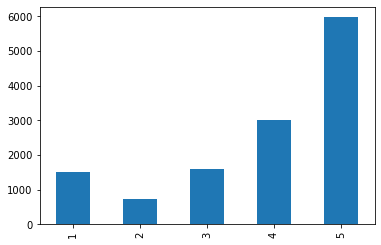

In [16]:
ratings["rate"].value_counts(sort=False).plot(kind='bar');

## Create Users Profiles

In [17]:
# Create users profiles
users_profiles = pr.get_user_profile(ratings)


# Find liked-items for each users
# if user rate an item K or more we consider it as a liked-item
K = 3
users_liked = pr.find_liked_items(users_profiles, K)


# Split user-liked items to test and train based on test-ratio
users_profiles_train, users_profiles_test = pr.split_user_profile(users_profiles, test_ratio=0.5)

# Collaborative Filtering

In [18]:
# Split data to train and test sets
train, test = pr.split_ratings_data(ratings, test_ratio=0.2)

In [19]:
sim_options = {
    "name": ["pearson"],
    "min_support": [5],
    "user_based": [True]
}

knn_param_grid = {'k': list(range(1,40,5)),
              'sim_options': sim_options,
              'verbose': [False]
             }

knn_algorithms = [KNNWithMeans, KNNWithZScore, KNNBaseline]

In [20]:
rmse = cf.batch_run('KNN', ratings, knn_algorithms, knn_param_grid)

<class 'surprise.prediction_algorithms.knns.KNNWithMeans'>
done in 29.589s.
Mean of the best RMSE across cross-validation:  1.1329444447408232
--------------------------------------------------------------------------
<class 'surprise.prediction_algorithms.knns.KNNWithZScore'>
done in 32.603s.
Mean of the best RMSE across cross-validation:  1.1327949028073363
--------------------------------------------------------------------------
<class 'surprise.prediction_algorithms.knns.KNNBaseline'>
done in 26.959s.
Mean of the best RMSE across cross-validation:  1.156206451151471
--------------------------------------------------------------------------


In [21]:
rmse

array([[1.13264795, 1.11923658, 1.13063589, 1.15969012, 1.12251169],
       [1.13233807, 1.11911358, 1.13088935, 1.15984721, 1.12178629],
       [1.17764659, 1.14298701, 1.1373939 , 1.17994683, 1.14305793]])

### Compare RMSEs across different KKN algorithms

#### Bar Cart

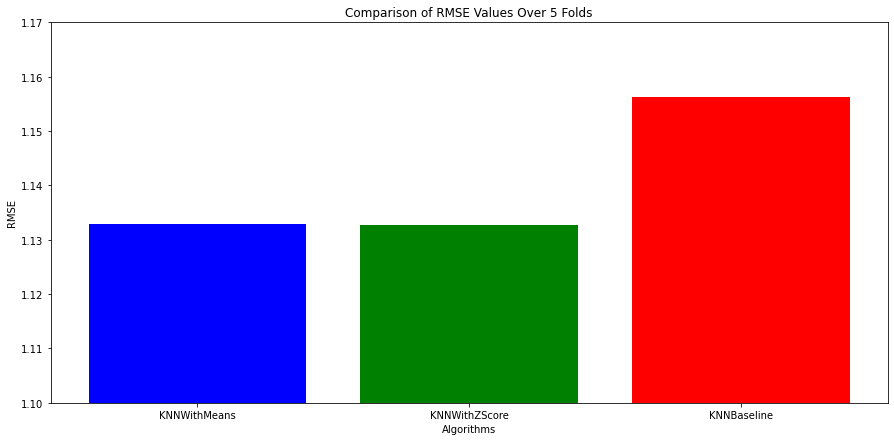

In [22]:
x = ['KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']
y = np.mean(rmse, axis=1)
x_label = 'Algorithms'
y_label = 'RMSE'
title = 'Comparison of RMSE Values Over 5 Folds'
x_lim = 1.1
y_lim = 1.17
ch.plot_bar(x, y, x_label, y_label, title, x_lim, y_lim)

#### Boxplot

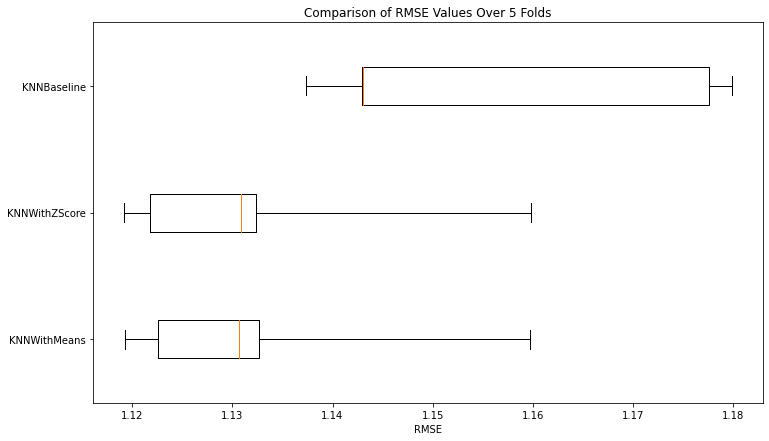

In [23]:
x = ['KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']
y = [rmse[0], rmse[1], rmse[2],]
x_label = 'RMSE'
y_label = ''
title = 'Comparison of RMSE Values Over 5 Folds'
ch.plot_box(x, y, x_label, y_label, title)

### Model Based Algorithms

In [24]:
param_grid =  {'n_epochs': [5],#, 10, 15], 
               'n_factors': [5],
               'lr_all': [0.0005],#, 0.002, 0.005, 0.007],
               'reg_all': [0.02]#, 0.2, 0.4, 0.6]
              }

algorithms = [SVD, SVDpp]

In [25]:
rmse = cf.batch_run('MODEL_BASED' ,ratings, algorithms, param_grid)

<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
done in 0.911s.
Mean of the best RMSE across cross-validation:  1.3222432062672147
--------------------------------------------------------------------------
<class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'>
done in 4.601s.
Mean of the best RMSE across cross-validation:  1.320114032403255
--------------------------------------------------------------------------


# Clustering

In [34]:
from sklearn.cluster import KMeans 
from scipy.sparse import csr_matrix

ratings_csr = csr_matrix((ratings.rate, (ratings.user , ratings.item)))
ratings_csr.shape

(1826, 802)

In [183]:
kmeans = KMeans(n_clusters=10, max_iter=500, random_state=11, verbose=0)

In [184]:
kmeans.fit(ratings_csr)

KMeans(max_iter=500, n_clusters=10, random_state=11)

In [185]:
clusters = kmeans.predict(ratings_csr)
clusters.shape

(1826,)

In [187]:
pd.options.display.float_format='{:,.2f}'.format

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.head()

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.00,0.06,0.00,0.11,0.00,0.00,0.05,0.00,0.00,0.00,...,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00
1,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.05,0.11,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [29]:
csr_ratings = clustering.get_sparse_matrix(ratings)
kmeans = clustering.KMeans(n_clusters=10, max_iter=500)
kmeans.fit(csr_ratings)
clusters = kmeans.predict(csr_ratings)

In [30]:
clustering.get_centroids(kmeans).head()

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.088889,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.022727,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.37037,0.0,0.0,0.148148,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


In [31]:
np.unique(clusters)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [32]:
len(clusters)

1826

In [29]:
# len(ratings[clusters == 3])

In [28]:
# clustering.cluster_sizes(clusters, ratings)

In [27]:
# cluster_labels = np.unique(clusters)
# size = {}
# n_clusters = cluster_labels.shape[0]

# for c in cluster_labels:
#     print('CCCCCCCCCC: ', c)
#     print(csr_ratings[clusters == c])
# #     size[c] = len(data[clusters == c])